## Tractography 

Tractography requires the following elements: 

- ODF peaks in each voxel based on a reconstruction model.
- A tissue classification criterion (we want to track only in the white matter!).
- Tracking seeds (where to start tracking).
- A direction getter - a rule for getting directions. 

That last one determines, for example, whether we are doing determinstic or probabilistic tracking.

Let's get started by getting some data. This time, we're also getting some Freesurfer labels associated with this 
data set:

In [1]:
from dipy.data import read_stanford_labels

hardi_img, gtab, labels_img = read_stanford_labels()
data = hardi_img.get_data()
labels = labels_img.get_data()
affine = hardi_img.affine

Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 


The white matter is labels '1' and '2' in the data:

In [2]:
white_matter = (labels == 1) | (labels == 2)

We fit the CSD model as before

In [3]:
from dipy.reconst.csdeconv import auto_response
response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

In [4]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [5]:
from dipy.direction import peaks_from_model
from dipy.data import default_sphere

### Peaks from model. 

The tracking will require a peak crea

In [6]:
csd_peaks = peaks_from_model(csd_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)

To make things interesting (and also because it's considered best practice), we'll use the generalized fractional anistropy (GFA) calculated from another reconst model (CSA) to determine our tissue classification:

In [7]:
from dipy.reconst.shm import CsaOdfModel
csa_model = CsaOdfModel(gtab, sh_order=6)

In [8]:
csa_fit = csa_model.fit(data, mask=white_matter)

In [9]:
GFA = csa_fit.gfa

In [10]:
from dipy.tracking.local import ThresholdTissueClassifier
classifier = ThresholdTissueClassifier(GFA, .25)

We seed in the corpus callosum (label '2' in the Freesurfer labels)

In [11]:
from dipy.tracking import utils

seed_mask = labels == 2
seeds = utils.seeds_from_mask(seed_mask, density=[2, 2, 2], affine=affine)

Finally, we are ready to put it all together, with the LocalTracking tracker:

In [12]:
from dipy.tracking.local import LocalTracking
streamlines = LocalTracking(csd_peaks, classifier, seeds, affine, step_size=.5)

In [13]:
type(streamlines)

dipy.tracking.local.localtracking.LocalTracking

This object is a Python 'generator' object. That means that computation is deferred until it is actually needed. This is useful in some situations where filtering of a massive number of streamlines is done, and you don't want to store them all in memory at once.

In this case, we can generate all the streamlines at once, by turning the generator into a list:

In [14]:
streamlines = list(streamlines)

### Question: what are the units and coordinate frame of the streamlines?

In [15]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

In [16]:
# Prepare the display objects.
color = line_colors(streamlines)
streamlines_actor = fvtk.line(streamlines, line_colors(streamlines))

/home/ubuntu/miniconda3/lib/python3.6/site-packages/dipy/viz/colormap.py:226: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


In [17]:
# Create the 3d display.
ren = fvtk.ren()

In [18]:
fvtk.add(ren, streamlines_actor)

In [19]:
# Save still images for this static example. 
fvtk.record(ren, n_frames=1, out_path='deterministic.png',
            size=(800, 800))

# For interactivity use fvtk.show (but only on a local machine!)
# fvtk.show(ren)

In [20]:
from IPython.display import display, Image

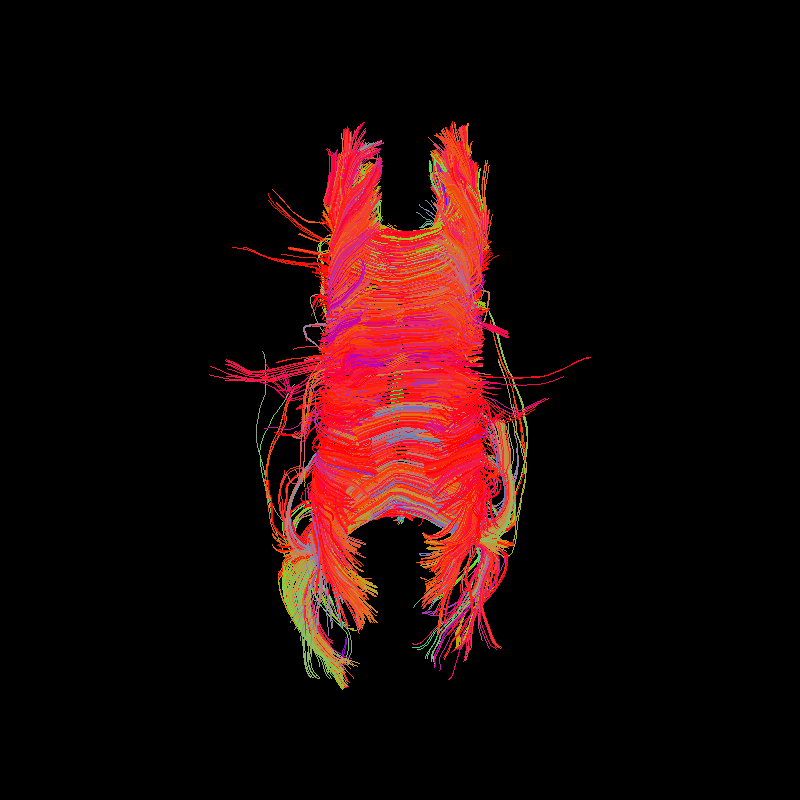

In [21]:
display(Image('deterministic.png'))

### Saving tracks to file: 

We can save the tracks directly to the standard `trk` file format: 


In [22]:
from dipy.io.trackvis import save_trk
save_trk("CSD_detr.trk", streamlines, affine, labels.shape)

### Probabilistic tracking

The difference between deterministic tracking and 

In [23]:
csd_fit = csd_model.fit(data, mask=white_matter)
shm_coeff = csd_fit.shm_coeff

In [24]:
from dipy.direction import ProbabilisticDirectionGetter

prob_dg = ProbabilisticDirectionGetter.from_shcoeff(shm_coeff,
                                                    max_angle=30.,
                                                    sphere=default_sphere)

In [25]:
streamlines = LocalTracking(prob_dg, classifier, seeds, affine,
                            step_size=.5, max_cross=2)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/dipy/viz/colormap.py:226: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


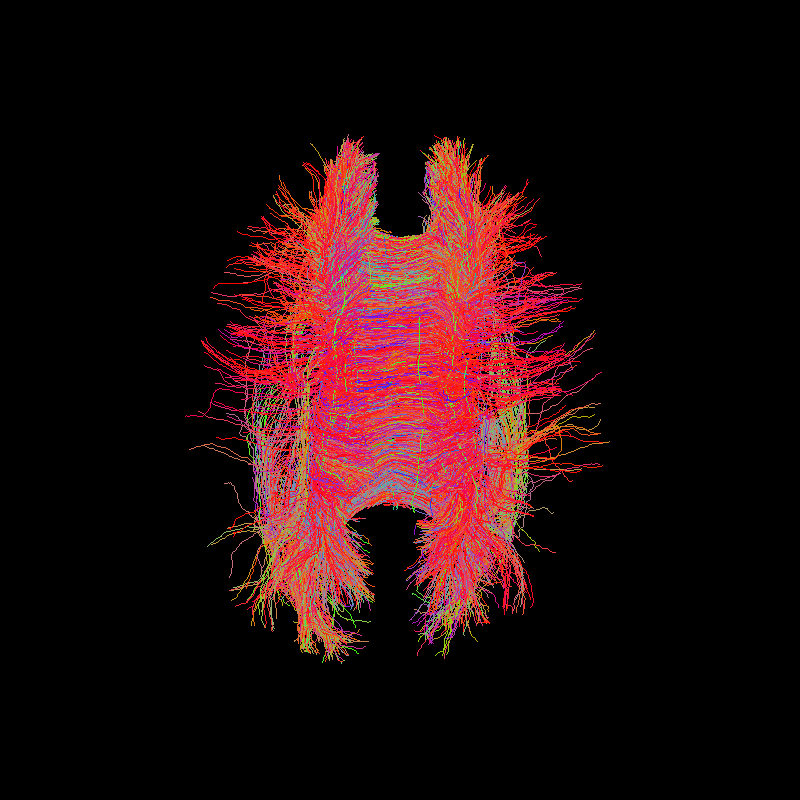

In [26]:
# Compute streamlines and store as a list.
streamlines = list(streamlines)

# Prepare the display objects.
color = line_colors(streamlines)
streamlines_actor = fvtk.line(streamlines, line_colors(streamlines))

# Create the 3d display.
ren = fvtk.ren()
fvtk.add(ren, streamlines_actor)

# Save still images for this static example.
fvtk.record(ren, n_frames=1, out_path='probabilistic.png',
            size=(800, 800))

# For interactivity use fvtk.show (but only on a local machine!)
# fvtk.show(ren)

display(Image('probabilistic.png'))

In [27]:
save_trk("CSD_prob.trk", streamlines, affine, labels.shape)

## Exercise: Can you track using the DTI model? Could you compare deterministic and probabilistic tracking with DTI?

Hint: A `peaks_from_model` object has a `shm_coeff` attribute that can be used to create a ProbabilisticDirectionGetter object using the `from_shcoeff` method.